In [153]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from skimage import io, img_as_ubyte
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preproc
import py_pcha
from sklearn.neighbors import KNeighborsClassifier
import random
import copy


import seaborn as sns

In [17]:
# Globals
_SEED = 0

In [18]:
# Set the paths for image files, labels etc
faces_path = "../data/Faces/"
labels_path = "../data/labels.csv"
names_path = "../data/filenames.txt"

In [19]:
# Read labels as pandas object from labels.csv
labels_columns = ['age', 'gender', 'race']
labels = pd.read_csv(labels_path)
labels = pd.DataFrame(data=labels.values, columns=labels_columns)

In [20]:
# filter labels
def filter_by_age(df, fromAge, toAge):
    return df[(df.age >= fromAge) & (df.age <=toAge)]

In [241]:
filtered_labels = filter_by_age(labels, 60,65 )
filtered_labels

,age,gender,race
20349,60,0,0
20350,60,0,0
20351,60,0,0
20352,60,0,0
20353,60,0,0
...,...,...,...
21333,65,1,3
21334,65,1,3
21335,65,1,3
21336,65,1,4


In [22]:
# Open a random image to get dimensions
test_img_name = 0
test_img = io.imread(faces_path+f"{test_img_name}.jpg", as_gray=True)
h, w = test_img.shape
del test_img

In [23]:
X = np.empty((len(filtered_labels), h*w))

for i, index in enumerate(filtered_labels.index):
    #print(i,index)
    a = io.imread(faces_path+f"{index}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
    
del a
print('Done loading images')

Done loading images


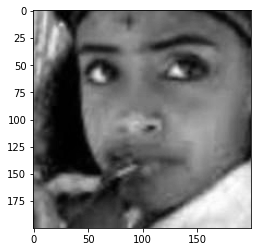

In [24]:
plt.imshow((X[0,:]).reshape(h,w), cmap='gray')

In [25]:
n_components = 9 # num components
k = 5 # number of nearest neighbours
knn = KNeighborsClassifier(n_neighbors=k)

In [26]:
y = filtered_labels["race"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)


In [240]:
ytrain

20802    0
20446    1
21274    0
20553    0
20645    0
        ..
20455    2
20619    1
21209    1
20784    0
20451    1
Name: race, Length: 741, dtype: int64

In [28]:
#Archetypal analysis
# Does not require that you center data
XC, S, C, SSE, varexpl = py_pcha.PCHA(Xtrain.T, noc=n_components, delta=0.1)
X_hat = Xtrain.T @ C @ S
L = 0.5*np.linalg.norm(Xtrain.T-X_hat)**2
components = XC.T

#knn.fit(S.T,ytrain)
Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S
#acc = knn.score(Xtest_transform.T,ytest)
X_test_hat = (XC @ Xtest_transform).T

#Reference to book notation
#XC = H transposed
#S = W (transposed, i suppose)
#SSE = Sum of Squared Errors




C:\Users\pf259\AppData\Local\Temp/ipykernel_6740/3183995633.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xtest_transform = np.linalg.lstsq(XC, Xtest.T)[0] #solve Xtest = XC @ S for S


In [29]:
#Convert PCHA output to nicer matrices
#B = C.T
#W = S.T
#H = XC.T

In [32]:
#Get indexes of the samples more significant for the archetypes
Xmain = np.zeros((n_components,3))

for i in range(len(B)):
    Xmain[i,:] = np.flip(np.argsort(C.T[i]))[0,:3]
Xmain = Xmain.astype(int)
for i, sample in enumerate(Xmain[0]):
    print(Xtrain[sample,:])


[ 26.  27.  29. ... 239. 239. 239.]
[126. 115. 110. ... 255. 255. 255.]
[157. 152. 146. ... 246. 246. 246.]


In [247]:
print(Xmain)

[[603  88 209]
 [652 336 511]
 [323 156 189]
 [344 732 278]
 [ 83 177 699]
 [560 473 725]
 [401 721 279]
 [ 51 102 737]
 [683 478 544]]


In [48]:
arch_len = np.array(range(len(Xmain))).reshape(-1,1)
arch_main = np.append(arch_len, Xmain, axis = 1)
arch_main

array([[  0, 603,  88, 209],
       [  1, 652, 336, 511],
       [  2, 323, 156, 189],
       [  3, 344, 732, 278],
       [  4,  83, 177, 699],
       [  5, 560, 473, 725],
       [  6, 401, 721, 279],
       [  7,  51, 102, 737],
       [  8, 683, 478, 544]])

In [248]:
#Helper functions
n_rows = 7 #for plotting
n_cols = 7 #for plotting

left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
image_shape = (h, w)
# Function for plotting images
def plot_components(title, components):
    plt.figure(figsize=(2. * n_cols, 2.26 * n_rows))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    start_index = random.randint(0, n)
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i + 1)
        # normalize colormap
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_recons(X, title, Nplot=100):
    plt.figure(figsize=(2. * 10, 2.26 * 10))
    plt.suptitle(title, size=24)
    # For each of the first 6 observations plot
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        # normalize colormap
        idx = random.randint(0, 210)
        comp = X[idx,:]
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        # Remove ticks from plot
        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)
    
def plot_arch_contributors(title, arch_main):
    '''
    Plot each archetype (first column) and the three most contributive samples that 
    define them
    '''
    #plt.figure(figsize=(image_shape[0]/100 * n_components, image_shape[1]/100 * np.shape(arch_main)[1]))
    plt.figure(figsize= (image_shape[1]/90 * np.shape(arch_main)[0], image_shape[0]/40 * n_components))
    plt.suptitle(title, size=24)
    pos = 0
    j = 0
    while j < len(arch_main):  
        for i, sample in enumerate(arch_main[j]):
            pos += 1
            if i == 0:
                comp = XC.T[sample,:]
            else:
                comp = Xtrain[sample,:]
            plt.subplot(n_components, np.shape(arch_main)[1], pos)
            # normalize colormap
            vmax = max(comp.max(), -comp.min())
            plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                       interpolation='nearest',
                       vmin=-vmax, vmax=vmax)
            # Remove ticks from plot
            plt.xticks(())
            plt.yticks(())
        j += 1

    plt.subplots_adjust(left, right, bottom, top, wspace, hspace)

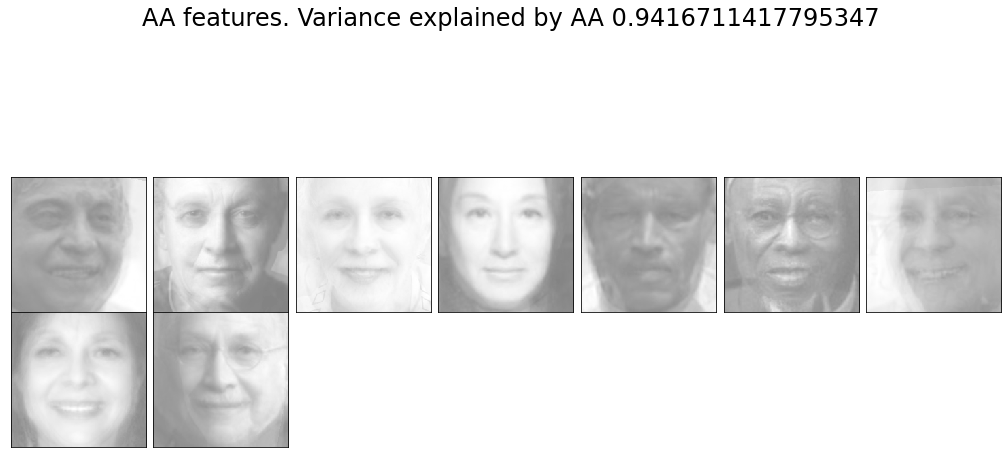

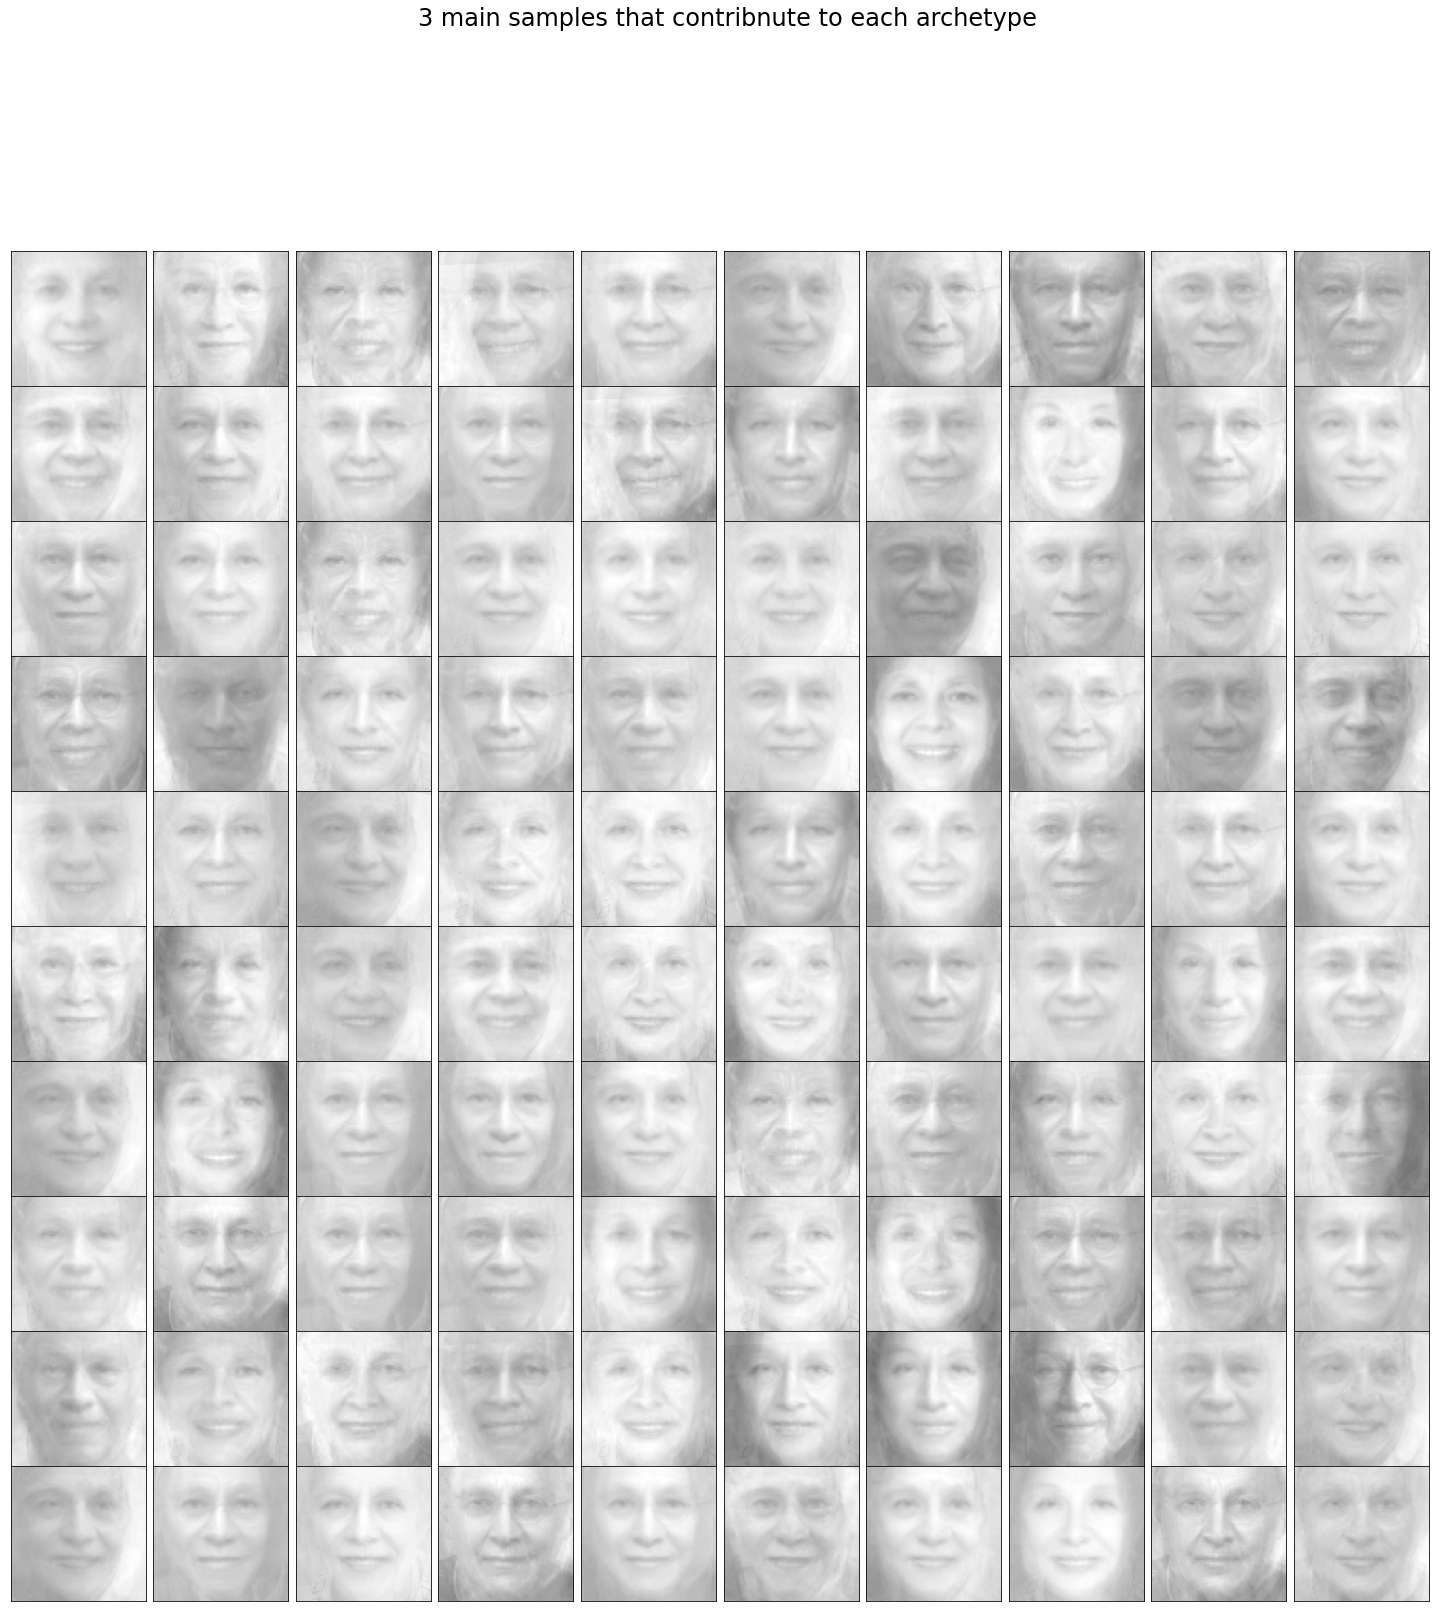

In [56]:
method = "AA"
SST = np.sum(np.sum(X**2))

plot_components(f'{method} features. Variance explained by {method} {1-2*L/SST}', components)
plot_recons(X_test_hat, f'{method} reconstructed digits. KNN accuracy using by {method} {acc}')

In [20]:
#Plot the original image to the center. To the left increase the contribution of the first archetype. To the right the second (plot 5 images for example)
    #xi = wi * H
    #w_index1 = index of the main arhcetype, 2_index2 = index of the second archetype
    #transformed_face = vector of len 5. stolen = sum( percentage * wi[>0]. Update values

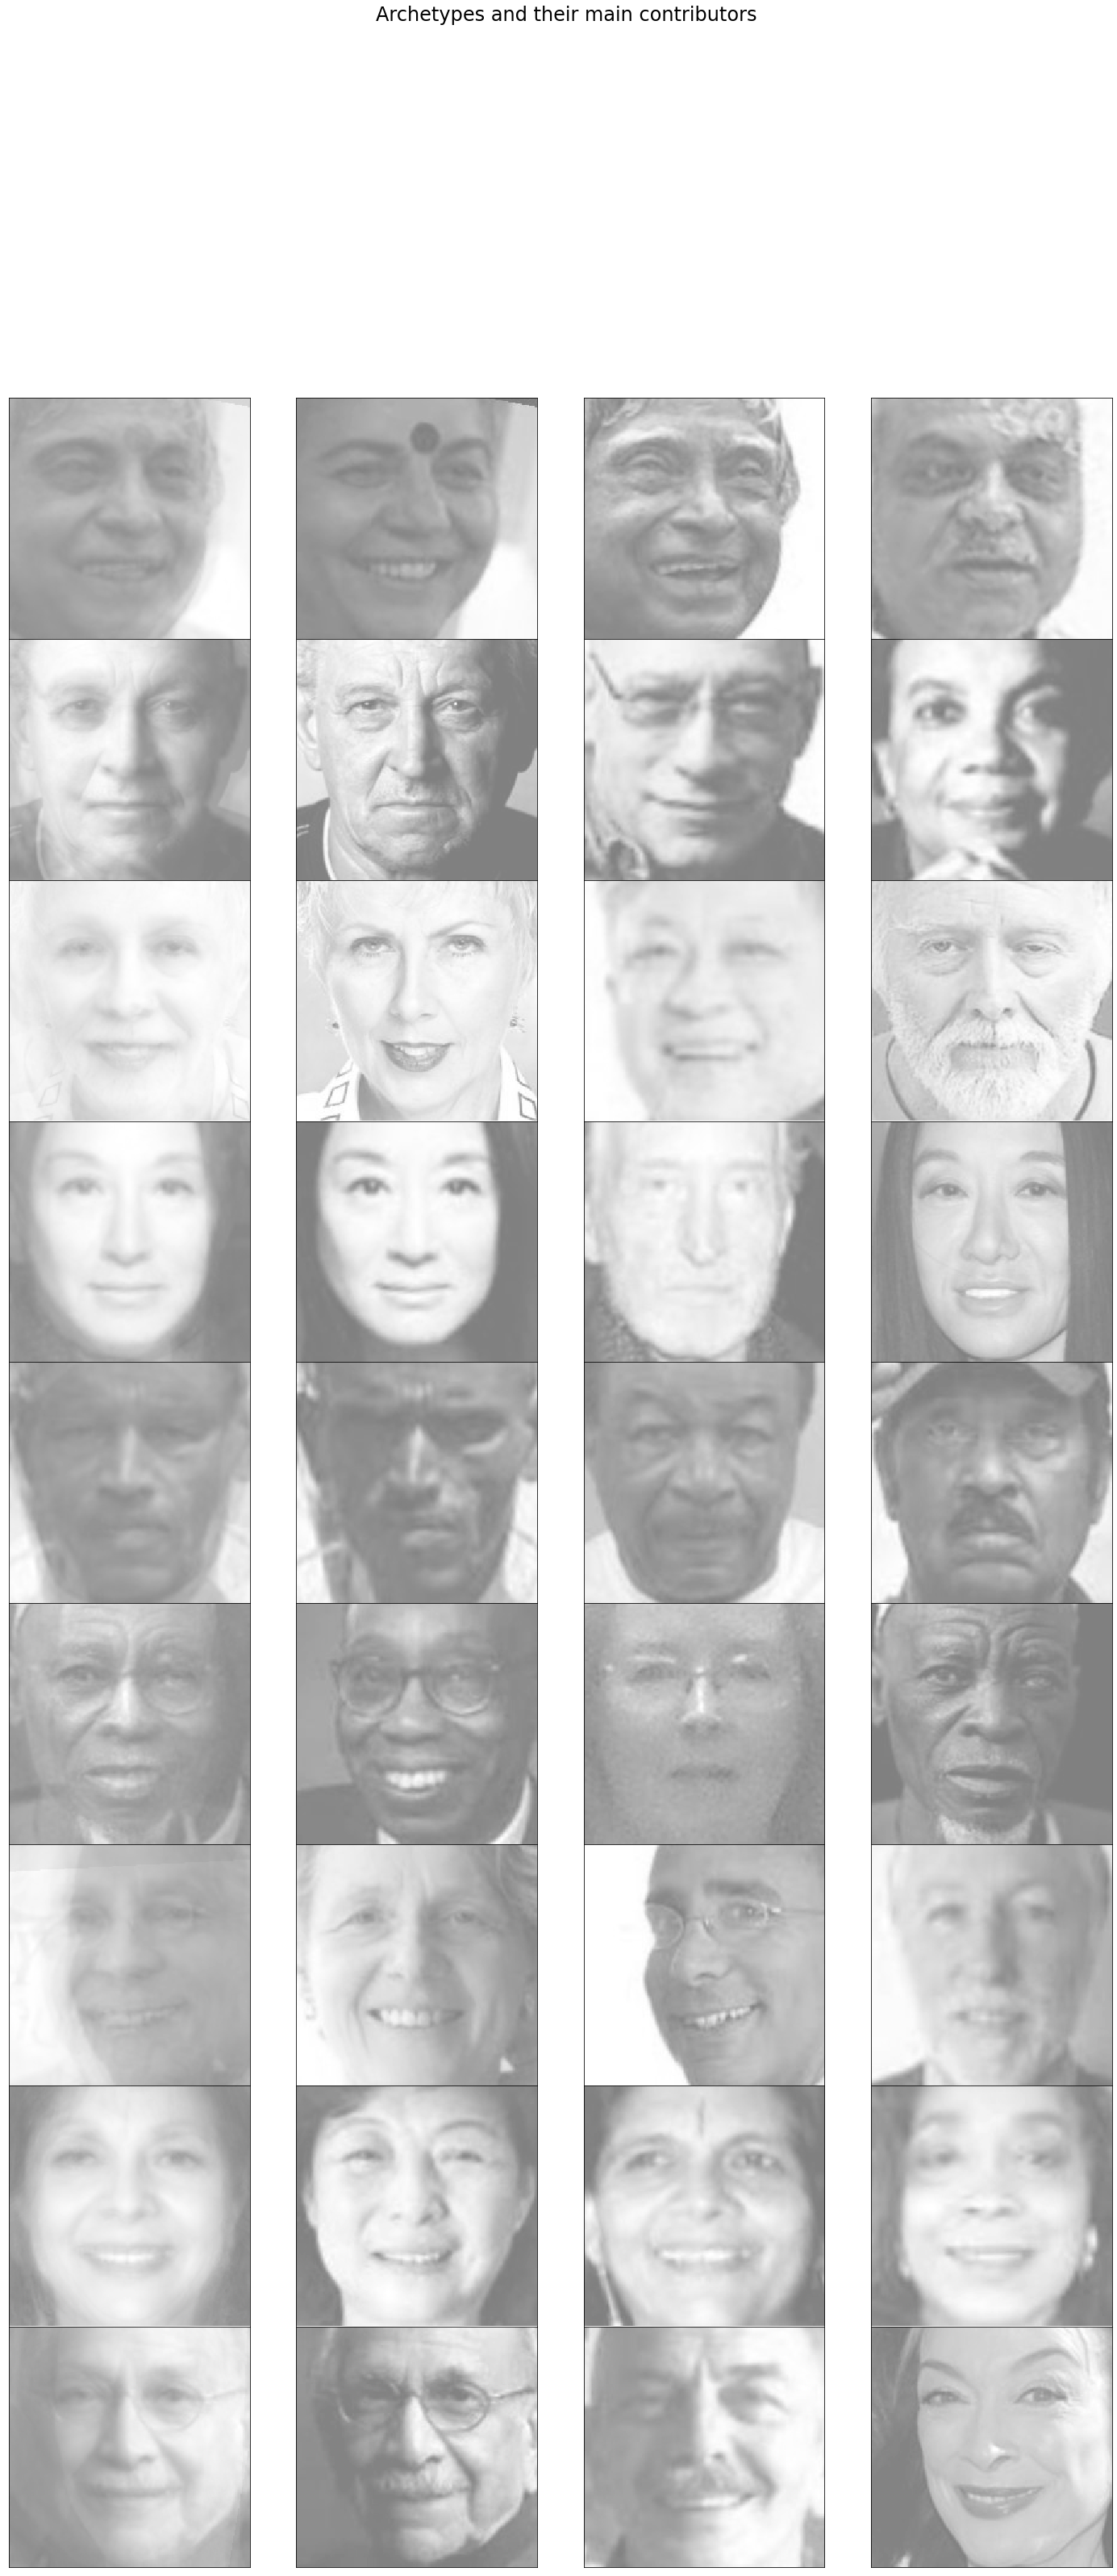

In [249]:
plot_arch_contributors('Archetypes and their main contributors', arch_main)

In [242]:
#Switch lables_codes to words
labels_words = copy.deepcopy(filtered_labels)

labels_words.loc[labels_words.gender == 0, "gender"] = "0_male"
labels_words.loc[labels_words.gender == 1, "gender"] = "1_female"
labels_words.loc[labels_words.race == 0, "race"] = "0_white"
labels_words.loc[labels_words.race == 1, "race"] = "1_black"
labels_words.loc[labels_words.race == 2, "race"] = "2_asian"
labels_words.loc[labels_words.race == 3, "race"] = "3_indian"
labels_words.loc[labels_words.race == 4, "race"] = "4_others"
bins = [0, 2, 4, 13, 20, 60, 200]
lab = ["0_infant", "1_toddler", "2_kid", "3_teen", "4_adult", "5_old"]
labels_words["age"] = pd.cut(labels_words["age"], bins = bins, labels = lab)
labels_words

,age,gender,race
20349,4_adult,0_male,0_white
20350,4_adult,0_male,0_white
20351,4_adult,0_male,0_white
20352,4_adult,0_male,0_white
20353,4_adult,0_male,0_white
...,...,...,...
21333,5_old,1_female,3_indian
21334,5_old,1_female,3_indian
21335,5_old,1_female,3_indian
21336,5_old,1_female,4_others


In [197]:
labels_words.iloc[0,:]

age         old
gender     male
race      white
Name: 0, dtype: object

In [192]:
score_male = 0
for i in range(np.shape(S.T)[0]):
    if "male" in list(labels_words.iloc[i,:]):
        score_male += S.T[i,1]
score_male


for i in range(np.shape(W)[0]):
    if label in list(labels_words.iloc[i,:]):
        

27.84849356613762

In [236]:
def arch_score_old(B, labels):
    '''
    labels = pandas df. Make sure that the values are unique across the whole dataset. 
             If there is an "A" in the first column, it must not be there in the others
    '''
    #Get all the unique values of the various labels, sorted   
    cols = []
    for i in range(labels.shape[1]):
        cols += sorted(list(labels.iloc[:,i].unique()))
    labels_values = np.array(cols) #List of the possible values of the labels, ordered "inside" each column
    print("Labels:",labels_values)
    score_matrix = np.zeros(shape=(np.shape(B)[0], len(labels_values)))
    
    for component_i in range(np.shape(score_matrix)[0]):
        for label_i in range(len(list(labels_values))):
            for sample_i in range(np.shape(B)[1]):
                if labels_values[label_i] in list(labels.iloc[sample_i,:]):
                    score_matrix[component_i, label_i] += B[component_i,sample_i]
    
    return score_matrix

In [ ]:
def arch_score(B, labels):
    '''
    labels = pandas df. Make sure that the values are unique across the whole dataset. 
             If there is an "A" in the first column, it must not be there in the others
    '''
    #Get all the unique values of the various labels, sorted   
    cols = []
    for i in range(labels.shape[1]):
        cols += sorted(list(labels.iloc[:,i].unique()))
    labels_values = np.array(cols) #List of the possible values of the labels, ordered "inside" each column
    print("Labels:",labels_values)
    score_matrix = np.zeros(shape=(np.shape(W)[1], len(labels_values)))
    
    for component_i in range(np.shape(score_matrix)[0]):
        #for label_i in range(len(list(labels_values))):
        for sample_i in range(np.shape(W)[0]):
            sample_labels = list(labels.iloc[sample_i,:])
            boh = np.where(labels_values == sample_labels)
            if labels_values[label_i] in list(labels.iloc[sample_i,:]):
                score_matrix[component_i, label_i] += W[sample_i,component_i]
    
    return score_matrix

In [190]:
#Get all the unique values of the various labels, sorted   
cols = []
for i in range(labels_words.shape[1]):
    cols += sorted(list(labels_words.iloc[:,i].unique()))
labels_values = np.array(cols)
list(labels_values)

['adult',
 'infant',
 'kid',
 'old',
 'teen',
 'toddler',
 'female',
 'male',
 'asian',
 'black',
 'indian',
 'others',
 'white']

In [243]:
arch_score_old(B = C.T, labels = labels_words)

Labels: ['4_adult' '5_old' '0_male' '1_female' '0_white' '1_black' '2_asian'
 '3_indian' '4_others']


array([[0.60584307, 0.49415693, 0.91513635, 0.18486365, 0.95552571,
        0.14447429, 0.        , 0.        , 0.        ],
       [0.        , 1.1       , 0.9934217 , 0.1065783 , 0.48265083,
        0.17486599, 0.        , 0.44248318, 0.        ],
       [0.55678896, 0.54321104, 0.68518152, 0.41481848, 0.66123537,
        0.13664318, 0.        , 0.30212145, 0.        ],
       [0.16957792, 0.93042208, 0.92461915, 0.17538085, 0.76926218,
        0.28880248, 0.04193535, 0.        , 0.        ],
       [0.77298072, 0.32701928, 0.80225141, 0.29774859, 1.06235343,
        0.        , 0.03764657, 0.        , 0.        ],
       [0.        , 1.1       , 0.40806164, 0.69193836, 1.09146083,
        0.        , 0.00853917, 0.        , 0.        ],
       [0.37115609, 0.72884391, 0.55652192, 0.54347808, 0.40178991,
        0.36880614, 0.        , 0.32940394, 0.        ],
       [0.55006724, 0.54993276, 0.97949343, 0.12050657, 0.66802929,
        0.35975798, 0.        , 0.07221273, 0.        ],


In [244]:
len(filtered_labels)

989

In [246]:
len(X)

989